<a href="https://colab.research.google.com/github/Innocente0/summative_model-training_and_evaluation/blob/main/model-training_and_evaluation_heart-disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Heart Disease Prediction using ML & DL project**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.data import Dataset

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)

##Load and Explore Data
In the 2 cells below, one is for loading data and the second is to check if we have any missing values. (There're no missing values in the dataset)

In [2]:
url = "https://raw.githubusercontent.com/Innocente0/summative_model-training_and_evaluation/refs/heads/main/heart.csv"
data = pd.read_csv(url)

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
print("Dataset Shape:", data.shape)
print("\nColumn Info:\n", data.info())
print("\nMissing values:\n", data.isnull().sum())
print("\nBasic statistics:\n", data.describe())

Dataset Shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

Column Info:
 None

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca

##Visual Exploration
We’ll see the correlation between cp, thalach, and target. This will help us understand which features influence prediction most.



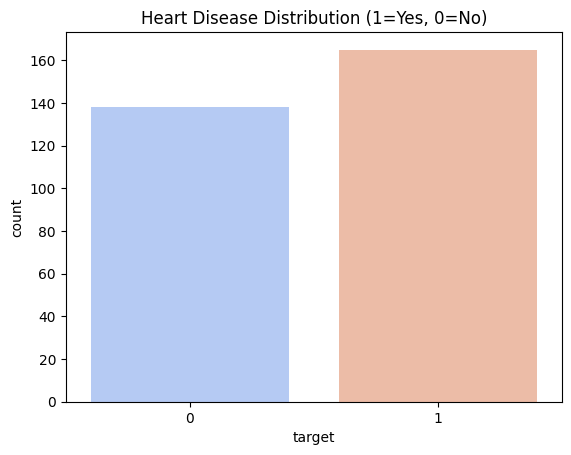

In [5]:
# Count of patients with and without heart disease
sns.countplot(x='target', data=data, palette='coolwarm')
plt.title("Heart Disease Distribution (1=Yes, 0=No)")
plt.show()


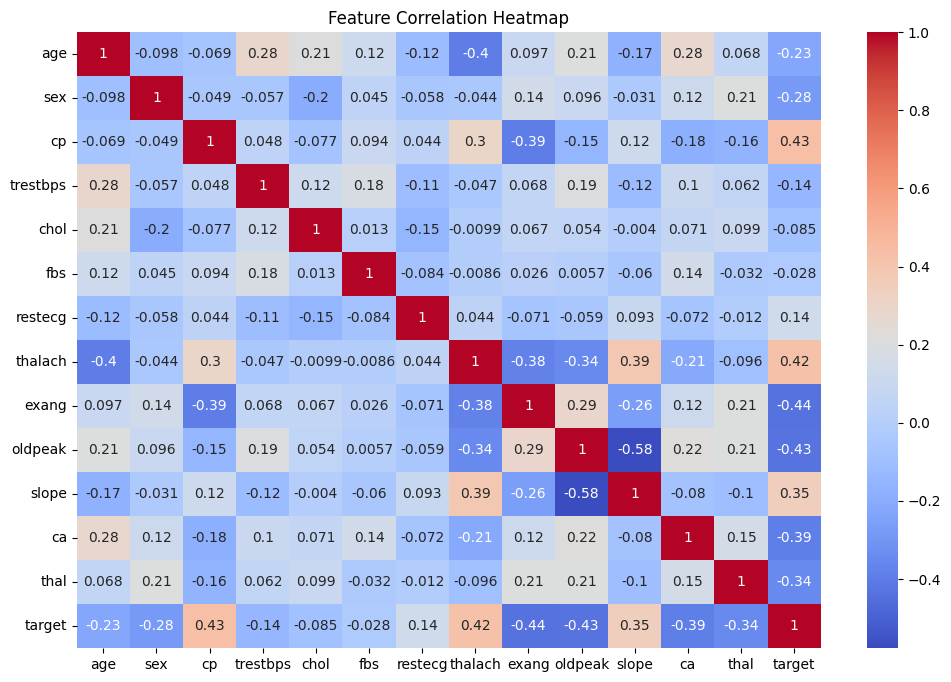

In [6]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##Preprocessing and Feature Engineering
Standardize all features. Then split them into 80% training, 20% testing with balanced classes.

In [7]:
# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

##Classical ML Models

In [8]:
#Logistic Rgression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_acc)

Logistic Regression Accuracy: 0.8032786885245902


In [9]:
#Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.819672131147541


In [10]:
#Support Vector Machine
svm = SVC(kernel='rbf', probability=True, C=2)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)

SVM Accuracy: 0.8032786885245902


In [11]:
#XGBoost
xgb = XGBClassifier(n_estimators=150, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("XGBoost Accuracy:", xgb_acc)

XGBoost Accuracy: 0.7704918032786885


##Evaluate ML Models
The diagram below is to visualize how each classical model performed.

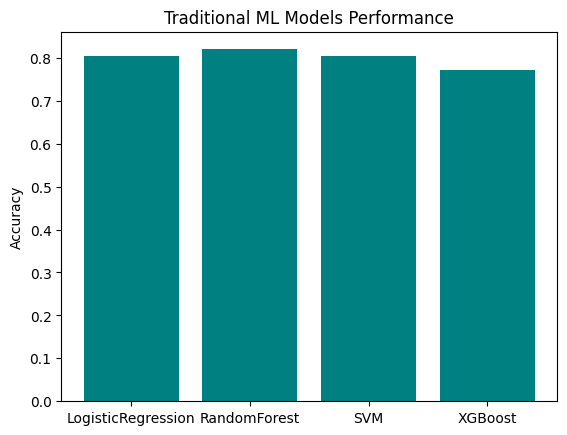

In [12]:
models = ['LogisticRegression','RandomForest','SVM','XGBoost']
accuracies = [lr_acc, rf_acc, svm_acc, xgb_acc]

plt.bar(models, accuracies, color='teal')
plt.ylabel("Accuracy")
plt.title("Traditional ML Models Performance")
plt.show()

##Deep Learning (Sequential API)

In [13]:
# Define Sequential model
seq_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

history_seq = seq_model.fit(
    X_train, y_train, epochs=100, batch_size=16,
    validation_split=0.2, callbacks=[es, lr_reduction], verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5483 - loss: 0.6926 - val_accuracy: 0.8367 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6992 - loss: 0.5778 - val_accuracy: 0.8367 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8190 - loss: 0.4991 - val_accuracy: 0.8571 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8608 - loss: 0.4334 - val_accuracy: 0.8776 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7920 - loss: 0.4292 - val_accuracy: 0.8776 - val_loss: 0.3290 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7990 - loss: 0.4232 - val_accuracy: 0.8776 - val_loss: 0.3151 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8734 - loss: 0.3779 - 

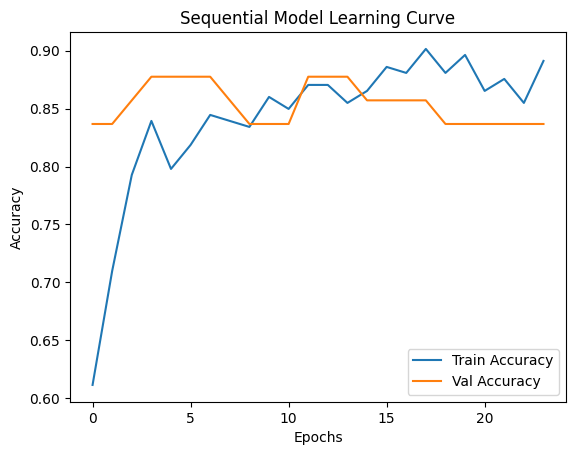

In [14]:
plt.plot(history_seq.history['accuracy'], label='Train Accuracy')
plt.plot(history_seq.history['val_accuracy'], label='Val Accuracy')
plt.title('Sequential Model Learning Curve')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

**Evaluate Sequential Model**

In [15]:
seq_pred = (seq_model.predict(X_test) > 0.5).astype("int32")
seq_acc = accuracy_score(y_test, seq_pred)
print("Sequential NN Accuracy:", seq_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Sequential NN Accuracy: 0.7704918032786885


##Deep Learning (Functional API)

In [16]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

func_model = Model(inputs, outputs)
func_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_func = func_model.fit(
    X_train, y_train, epochs=100, batch_size=16,
    validation_split=0.2, callbacks=[es, lr_reduction], verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4027 - loss: 0.8117 - val_accuracy: 0.5510 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5607 - loss: 0.6920 - val_accuracy: 0.7959 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6897 - loss: 0.6262 - val_accuracy: 0.8163 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7401 - loss: 0.5722 - val_accuracy: 0.8367 - val_loss: 0.4796 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7726 - loss: 0.5300 - val_accuracy: 0.8367 - val_loss: 0.4379 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8331 - loss: 0.4857 - val_accuracy: 0.8367 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7990 - loss: 0.4789 - 

**Evaluate Functional Model**

In [17]:
func_pred = (func_model.predict(X_test) > 0.5).astype("int32")
func_acc = accuracy_score(y_test, func_pred)
print("Functional NN Accuracy:", func_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Functional NN Accuracy: 0.8032786885245902


##Confusion Matrix & ROC

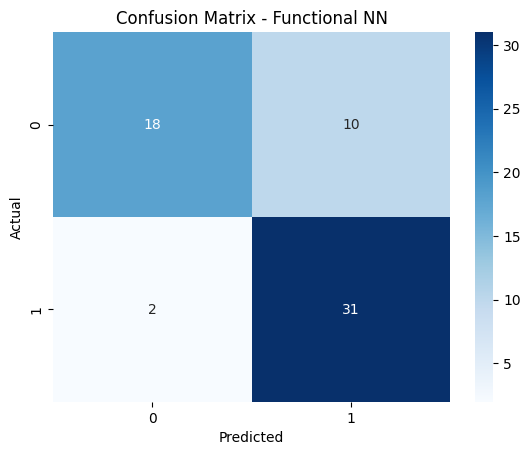

In [19]:
from sklearn.metrics import roc_curve, auc

#Functional NN confusion matrix
cm = confusion_matrix(y_test, func_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Functional NN")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


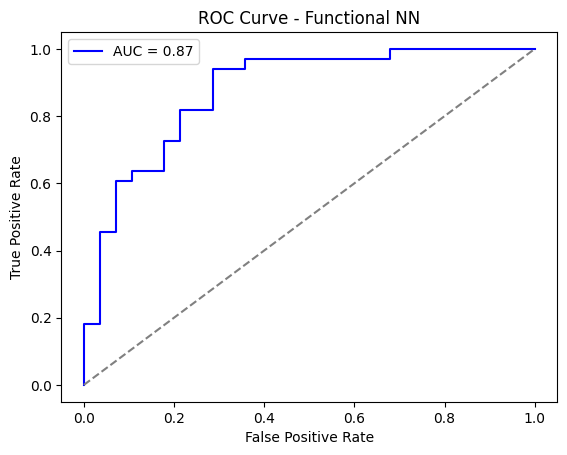

In [20]:
# ROC Curve
y_prob = func_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Functional NN")
plt.legend(); plt.show()

##Results

In [22]:
# Create a DataFrame with model results
results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

# Save the results to a CSV file
results_df.to_csv("heart_disease_model_comparison.csv", index=False)
print("Results saved successfully.")

Results saved successfully.
